# Predicting cab orders

Chetnye Taxi has collected historical data on cab orders at airports. In order to attract more drivers during the peak period, we need to predict the number of cab orders for the next hour. Build a model for such a prediction.

The value of the *RMSE* metric on the test sample should be at most 48.

You need to:

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of size 10% of the original data.
4. Validate the data on the test sample and draw conclusions.


The data is in the file `taxi.csv`. The number of orders is in the `num_orders` column.

## Preparation

In [18]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.datasets import make_regression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV,train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv',index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

In [4]:
df.isna().sum()

num_orders    0
dtype: int64

In [5]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Let's look at the distribution of the feature from the third persentile to the maximum

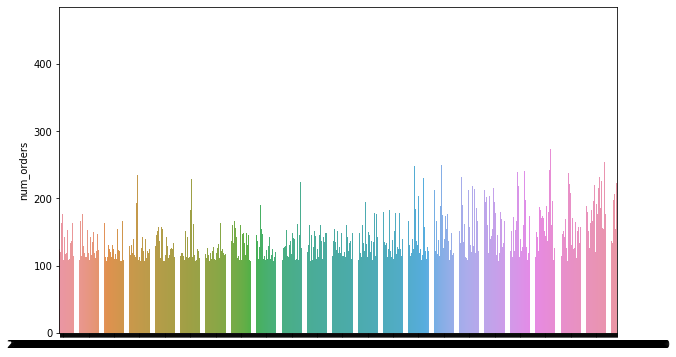

In [6]:
filtered_df = df[df['num_orders']>=107]

plt.figure(figsize=(10, 6))
sns.barplot(x=filtered_df.index, y=filtered_df['num_orders']).set(xlabel=None)
plt.show()

Let's not get rid of the maximum value

## Analysis

<AxesSubplot:xlabel='datetime'>

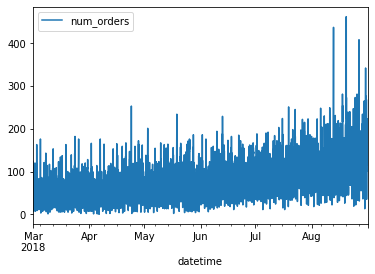

In [7]:
df.plot()

We see an increase in orders from March through August. Let's look at trends and moving average. We will not look at seasonality, as there is not enough data for that

<AxesSubplot:xlabel='datetime'>

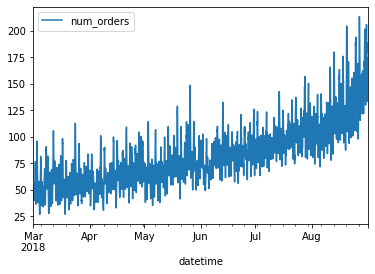

In [8]:
df.rolling(10).mean().plot()

In [9]:
decomposed = seasonal_decompose(df)

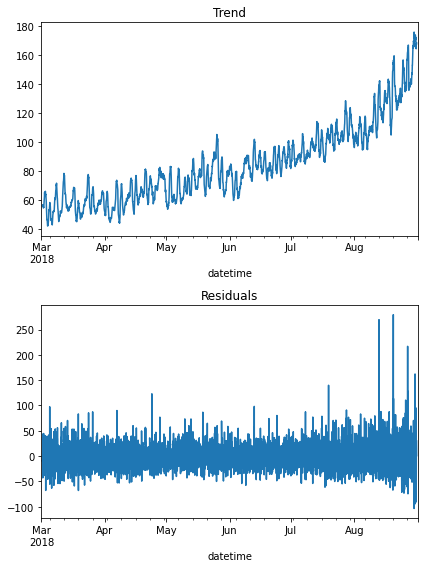

In [10]:
plt.figure(figsize=(6, 8))
plt.subplot(211)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(212)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Really see a growing trend in the number of airport cab bookings. This may be due to the increase in the number of trips during the vacation season. 



Let's write a function to create new features, find the optimal number of features 

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    """
    creating year, month, day, day of week, lagged value and moving average attributes
    """

    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.fillna(data.median(), inplace=True)

## Training

Let's create a dictionary of hyperparameters and models

In [12]:
models_params = {
    'Decision Tree Regressor': {
        'model': DecisionTreeRegressor(),
        'params': {'max_depth': range(1, 21), 'min_samples_split': range(2, 11), 
                   'min_samples_leaf': range(1, 11)}
    },
    'Random Forest Regressor': {
        'model': RandomForestRegressor(),
        'params': {'n_estimators': [10, 50, 100, 200], 'max_depth': range(1, 21)}
    },
    'Gradient Boosting Regressor': {
        'model': GradientBoostingRegressor(),
        'params': {'n_estimators': [10, 50, 100, 200], 'learning_rate': [0.001, 0.01, 0.1], 
                   'max_depth': range(1, 11)}
    },
    'CatBoost Regressor': {
        'model': CatBoostRegressor(silent=True),
        'params': {'learning_rate': [0.03, 0.1], 'depth': [4, 7, 10], 
                   'l2_leaf_reg': [1, 3, 5, 7, 9]}
    }
}

In [13]:
best_results = {}

max_lags = [1, 7, 14, 30]
rolling_mean_sizes = [1, 7, 14, 30]

In [28]:
def train_model(model_name):
    tscv = TimeSeriesSplit(n_splits=5)
    best_results = {}

    for max_lag in max_lags:
        for rolling_mean_size in rolling_mean_sizes:
            make_features(df, max_lag, rolling_mean_size)

            X = df.drop('num_orders', axis=1)
            y = df['num_orders']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                                random_state=42, shuffle=False)
            
            gs = GridSearchCV(models_params[model_name]['model'], models_params[model_name]['params'], 
                              cv=tscv, scoring='neg_mean_squared_error')
            gs.fit(X_train, y_train)

            if model_name not in best_results or -gs.best_score_ < best_results[model_name]['Best Score']:
                best_results[model_name] = {'Best Score': -gs.best_score_,
                                            'Best Parameters': gs.best_params_, 
                                            'max_lag': max_lag, 
                                            'rolling_mean_size': rolling_mean_size}

    print(f"Best results for {model_name}:")
    print(best_results[model_name])

    # Use best_estimator_ for final prediction on the test set
    best_model = gs.best_estimator_
    predicted_test = best_model.predict(X_test)
    final_rmse = (mean_squared_error(y_test, predicted_test))**0.5
    best_results[model_name]['Final RMSE'] = final_rmse
    print(f"Final RMSE on test data: {final_rmse}")

    return best_model

### Linear Regression

In [24]:
params = {'fit_intercept': [True, False], 'normalize': [True, False]}

tscv = TimeSeriesSplit(n_splits=5)
model = LinearRegression()

for max_lag in max_lags:
    for rolling_mean_size in rolling_mean_sizes:
        make_features(df, max_lag, rolling_mean_size)

        X = df.drop('num_orders', axis=1)
        y = df['num_orders']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

        scaler = StandardScaler()
        X_train_scaled = X_train.copy()
        X_test_scaled = X_test.copy()

        numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
        X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
        X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

        gs = GridSearchCV(model, params, cv=tscv, scoring='neg_mean_squared_error')
        gs.fit(X_train_scaled, y_train)

        if 'Best Score' not in best_results or -gs.best_score_ < best_results['Best Score']:
            best_results['Linear Regression'] = {'Best Score': -gs.best_score_, 'RMSE': final_rmse, 'Best Parameters': gs.best_params_, 
                            'max_lag': max_lag, 'rolling_mean_size': rolling_mean_size}

print("Best results for Linear Regression:")
print(best_results['Linear Regression'])

best_model = gs.best_estimator_
predicted_test = best_model.predict(X_test_scaled)
final_rmse = (mean_squared_error(y_test, predicted_test))**0.5
print(f"Final RMSE on test data: {final_rmse}")

Best results for Linear Regression:
{'Best Score': 742.614569247577, 'RMSE': 45.091761588593776, 'Best Parameters': {'fit_intercept': True, 'normalize': True}, 'max_lag': 30, 'rolling_mean_size': 30}
Final RMSE on test data: 45.091761588593776


### Decision Tree Regressor

In [29]:
train_model('Decision Tree Regressor')

Best results for Decision Tree Regressor:
{'Best Score': 866.1425222807563, 'Best Parameters': {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}, 'max_lag': 1, 'rolling_mean_size': 7}
Final RMSE on test data: 53.84688855632255


DecisionTreeRegressor(max_depth=5, min_samples_leaf=9)

### Random Forest Regressor

In [30]:
train_model('Random Forest Regressor')

Best results for Random Forest Regressor:
{'Best Score': 668.3318759414362, 'Best Parameters': {'max_depth': 18, 'n_estimators': 200}, 'max_lag': 30, 'rolling_mean_size': 7}
Final RMSE on test data: 43.765645158239025


RandomForestRegressor(max_depth=14, n_estimators=200)

### Gradient Boosting Regressor

In [31]:
train_model('Gradient Boosting Regressor')

Best results for Gradient Boosting Regressor:
{'Best Score': 665.2207187554507, 'Best Parameters': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}, 'max_lag': 7, 'rolling_mean_size': 7}
Final RMSE on test data: 43.65786697923463


GradientBoostingRegressor(max_depth=6)

### CatBoost Regressor

In [ ]:
train_model('CatBoost Regressor')

## Testing

In [ ]:
print(best_results)

In [ ]:
models = list(best_results.keys())
rmse_values = [model_data['RMSE'] for model_data in best_results.values()]

bars = plt.bar(models, rmse_values, color='c')

plt.title("RMSE Values for Different Models")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.xticks(rotation=45)  

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()



The best result was achieved by **CatBoos tRegressor** with RMSE 41.5, second place was taken by **Random Forest Regressor** with RMSE 43.13.

The worst result was shown by Decision Tree Regressor and it used to exceed the threshold of RMSE 48